In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

<h1>1. GBDT (xgboost/lightgbm) </h1>

## Loading Data

In [ ]:
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing the Dataset with 5000 rows for ease of computation

In [ ]:
data = pd.read_csv('/home/satya_anuragh/preprocessed_data.csv')

In [ ]:
print(data.shape)
print(data.head())

(109248, 9)
  school_state  ...   price
0           ca  ...  725.05
1           ut  ...  213.03
2           ca  ...  329.00
3           ga  ...  481.04
4           wa  ...   17.74

[5 rows x 9 columns]


In [ ]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   school_state                                  109248 non-null  object 
 1   teacher_prefix                                109248 non-null  object 
 2   project_grade_category                        109248 non-null  object 
 3   teacher_number_of_previously_posted_projects  109248 non-null  int64  
 4   project_is_approved                           109248 non-null  int64  
 5   clean_categories                              109248 non-null  object 
 6   clean_subcategories                           109248 non-null  object 
 7   essay                                         109248 non-null  object 
 8   price                                         109248 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 

In [ ]:
data1=pd.read_csv('/home/satya_anuragh/preprocessed_data.csv',nrows=50000)

In [ ]:
Y=data1["project_is_approved"]
X= data1.drop("project_is_approved", axis=1)

Splitting the Data into Train, Cross-Validation and the Test Datasets

In [ ]:
train_x,test_x,train_y,test_y= train_test_split(X,Y,test_size=0.2, stratify=Y)
train_x,cv_x,train_y,cv_y= train_test_split(train_x,train_y, test_size=0.2, stratify= train_y)

In [ ]:
print(train_x.shape)
print(cv_x.shape)
print(test_x.shape)
print(train_y.shape)
print(cv_y.shape)
print(test_y.shape)

(69918, 8)
(17480, 8)
(21850, 8)
(69918,)
(17480,)
(21850,)


Encoding the Essay column using the TFIDF Vectorizer. Fitting on the train data

In [ ]:
tr_tfidf_df= pd.DataFrame(columns=["essay"],index= range(train_x.shape[0]))
cv_tfidf_df= pd.DataFrame(columns=["essay"],index= range(cv_x.shape[0]))
te_tfidf_df= pd.DataFrame(columns=["essay"],index= range(test_x.shape[0]))

In [ ]:
vect1= TfidfVectorizer()
vect1.fit(data["essay"])

TfidfVectorizer()

Transforming the Essay variable of the Train, CV and Test datasets using the essay data fitted on the Train_X["essay"] variable

In [ ]:
tr_tfidf_df= vect1.transform(train_x["essay"])
cv_tfidf_df= vect1.transform(cv_x["essay"])
te_tfidf_df= vect1.transform(test_x["essay"])

In [ ]:
print(tr_tfidf_df.shape)

(32000, 56345)


In [ ]:
print(type(tr_tfidf_df))

<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
tsvd3k= TruncatedSVD(n_components=3000)
tsvd3k.fit(tr_tfidf_df)
tsvd3k_var_ratios= tsvd3k.explained_variance_ratio_

In [ ]:
tr_tfidf_trun= tsvd3k.transform(tr_tfidf_df)
cv_tfidf_trun= tsvd3k.transform(cv_tfidf_df)
te_tfidf_trun= tsvd3k.transform(te_tfidf_df)

In [ ]:
print(tr_tfidf_trun.shape)
print(cv_tfidf_trun.shape)
print(te_tfidf_trun.shape)

(69918, 3000)
(17480, 3000)
(21850, 3000)


In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_3K.pkl','wb') as tr3k:
    pickle.dump(tr_tfidf_trun,tr3k)
with open('/home/satya_anuragh/'+'cv_tfidf_3K.pkl','wb') as cv3k:
    pickle.dump(cv_tfidf_trun,cv3k)
with open('/home/satya_anuragh/'+'te_tfidf_3K.pkl','wb') as te3k:
    pickle.dump(te_tfidf_trun,te3k)

In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_3K.pkl','rb') as tr3k:
    tr_tfidf_trun3k= pickle.load(tr3k)
with open('/home/satya_anuragh/'+'cv_tfidf_3K.pkl','rb') as cv3k:
    cv_tfidf_trun3k= pickle.load(cv3k)
with open('/home/satya_anuragh/'+'te_tfidf_3K.pkl','rb') as te3k:
    te_tfidf_trun3k= pickle.load(te3k)

In [ ]:
tsvd5k= TruncatedSVD(n_components=5000)
tsvd5k.fit(tr_tfidf_df)
tsvd5k_var_ratios= tsvd5k.explained_variance_ratio_

In [ ]:
tr_tfidf_trun5= tsvd5k.transform(tr_tfidf_df)
cv_tfidf_trun5= tsvd5k.transform(cv_tfidf_df)
te_tfidf_trun5= tsvd5k.transform(te_tfidf_df)

In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_5K.pkl','wb') as tr5k:
    pickle.dump(tr_tfidf_trun5,tr5k)
with open('/home/satya_anuragh/'+'cv_tfidf_5K.pkl','wb') as cv5k:
    pickle.dump(cv_tfidf_trun,cv5k)
with open('/home/satya_anuragh/'+'te_tfidf_5K.pkl','wb') as te5k:
    pickle.dump(te_tfidf_trun,te5k)

In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_5K.pkl','rb') as tr5k:
    tr_tfidf_trun5k= pickle.load(tr5k)
with open('/home/satya_anuragh/'+'cv_tfidf_5K.pkl','rb') as cv5k:
    cv_tfidf_trun5k= pickle.load(cv5k)
with open('/home/satya_anuragh/'+'te_tfidf_5K.pkl','rb') as te5k:
    te_tfidf_trun5k= pickle.load(te5k)

###<font color='red'><b> Preparing the Datasets using the TFIDF Vectorizer</b></font>

Importing the Normalizer and assigning the Normalizer to norm variable.

In [ ]:
scaler= StandardScaler()

Fitting the Normalizer on the Train_x["Price"] variable.

In [ ]:
norm_cols=["price","teacher_number_of_previously_posted_projects"]

In [ ]:
tr_norm_df= pd.DataFrame(columns= norm_cols, index= range(train_x.shape[0]))
cv_norm_df= pd.DataFrame(columns= norm_cols, index= range(cv_x.shape[0]))
te_norm_df= pd.DataFrame(columns= norm_cols, index= range(test_x.shape[0]))

In [ ]:
scaler.fit(np.array(train_x["price"]).reshape(-1,1))

StandardScaler()

In [ ]:
tr_norm_df["price"]= scaler.transform(np.array(train_x["price"]).reshape(-1,1))
cv_norm_df["price"]= scaler.transform(np.array(cv_x["price"]).reshape(-1,1))
te_norm_df["price"]= scaler.transform(np.array(test_x["price"]).reshape(-1,1))

In [ ]:
scaler.fit(np.array(train_x['teacher_number_of_previously_posted_projects']).reshape(-1,1))

StandardScaler()

In [ ]:
tr_norm_df['teacher_number_of_previously_posted_projects']= scaler.transform(np.array(train_x['teacher_number_of_previously_posted_projects']).reshape(-1,1))
cv_norm_df['teacher_number_of_previously_posted_projects']= scaler.transform(np.array(cv_x['teacher_number_of_previously_posted_projects']).reshape(-1,1))
te_norm_df['teacher_number_of_previously_posted_projects']= scaler.transform(np.array(test_x['teacher_number_of_previously_posted_projects']).reshape(-1,1))

Defining a response function to get the number of datasets wiht a Y value of 1 and 0 

In [ ]:
col_list=['ss_p','ss_n','tp_p','tp_n','pgc_p','pgc_n','cc_p','cc_n','cs_p','cs_n']

In [ ]:
tr_response_df= pd.DataFrame(columns= col_list, index=range(train_x.shape[0]))
cv_response_df= pd.DataFrame(columns= col_list, index=range(cv_x.shape[0]))
te_response_df= pd.DataFrame(columns= col_list, index=range(test_x.shape[0]))
print(tr_response_df.shape)
print(cv_response_df.shape)
print(te_response_df.shape)

(32000, 10)
(8000, 10)
(10000, 10)


In [ ]:
def response(a,b):
    #b_array= np.array(b)
    #a_array= np.array(a)
    uni= np.unique(a)
    zer=[]
    one=[]
    z_prob=[]
    o_prob=[]

    for u in uni:
        z=0
        n=0
        #print(u)
        for row in range(len(a)):
            #print(a[row])
            if a[row]==u and b[row]==0:
                z=z+1
            elif a[row]==u and b[row]==1:
                n=n+1
        zer.append(z)
        one.append(n)

    for p in range(len(uni)):
        z_p= zer[p]/(zer[p]+one[p])
        o_p= one[p]/(zer[p]+one[p])
        z_prob.append(z_p)
        o_prob.append(o_p)
    
    d_z= dict(zip(uni,z_prob))
    d_o= dict(zip(uni,o_prob))

    return d_z,d_o

Defining a prob_response function to get the probablities for each of the 1 and 0 values of the Y variable

In [ ]:
def response_coding(tr_col,cv_col,y_col):   
    tr_array= np.array(tr_col)
    cv_array= np.array(cv_col)
    y_array=  np.array(y_col)
    uni= np.unique(tr_array)
    n_z_r=[]
    n_o_r=[]
    z,o= response(tr_array,y_array)

    for row in tqdm(range(len(cv_array))):
        if cv_array[row] in uni:
            z_v= z[cv_array[row]]
            o_v= o[cv_array[row]]
        else:
            z_v= 0.5
            o_v= 0.5
        n_z_r.append(z_v)
        n_o_r.append(o_v)
    return n_z_r,n_o_r

Response Coding of the School_State Variable

In [ ]:
tr_ss_p,tr_ss_n= response_coding(train_x["school_state"],train_x["school_state"],train_y)
cv_ss_p,cv_ss_n= response_coding(train_x["school_state"],cv_x["school_state"],train_y)
te_ss_p,te_ss_n= response_coding(train_x["school_state"],test_x["school_state"],train_y)

100%|██████████| 10000/10000 [00:00<00:00, 148558.76it/s]


In [ ]:
tr_response_df['ss_p']= tr_ss_p
tr_response_df['ss_n']= tr_ss_n

cv_response_df['ss_p']= cv_ss_p
cv_response_df['ss_n']= cv_ss_n

te_response_df['ss_p']= te_ss_p
te_response_df['ss_n']= te_ss_n

Response Coding of the Teacher_Prefix Variable

In [ ]:
tr_tp_p,tr_tp_n= response_coding(train_x["teacher_prefix"],train_x["teacher_prefix"],train_y)
cv_tp_p,cv_tp_n= response_coding(train_x["teacher_prefix"],cv_x["teacher_prefix"],train_y)
te_tp_p,te_tp_n= response_coding(train_x["teacher_prefix"],test_x["teacher_prefix"],train_y)

100%|██████████| 10000/10000 [00:00<00:00, 166313.92it/s]


In [ ]:
tr_response_df['tp_p']= tr_tp_p
tr_response_df['tp_n']= tr_tp_n

cv_response_df['tp_p']= cv_tp_p
cv_response_df['tp_n']= cv_tp_n

te_response_df['tp_p']= te_tp_p
te_response_df['tp_n']= te_tp_n

Response Coding of the Project_Grafe_Category Variable

In [ ]:
tr_pgc_p,tr_pgc_n= response_coding(train_x["project_grade_category"],train_x["project_grade_category"],train_y)
cv_pgc_p,cv_pgc_n= response_coding(train_x["project_grade_category"],cv_x["project_grade_category"],train_y)
te_pgc_p,te_pgc_n= response_coding(train_x["project_grade_category"],test_x["project_grade_category"],train_y)

100%|██████████| 10000/10000 [00:00<00:00, 164418.03it/s]


In [ ]:
tr_response_df['pgc_p']= tr_pgc_p
tr_response_df['pgc_n']= tr_pgc_n

cv_response_df['pgc_p']= cv_pgc_p
cv_response_df['pgc_n']= cv_pgc_n

te_response_df['pgc_p']= te_pgc_p
te_response_df['pgc_n']= te_pgc_n

Response Coding of the Clean_Categories Variable

In [ ]:
tr_cc_p,tr_cc_n= response_coding(train_x["clean_categories"],train_x["clean_categories"],train_y)
cv_cc_p,cv_cc_n= response_coding(train_x["clean_categories"],cv_x["clean_categories"],train_y)
te_cc_p,te_cc_n= response_coding(train_x["clean_categories"],test_x["clean_categories"],train_y)

100%|██████████| 10000/10000 [00:00<00:00, 148164.64it/s]


In [ ]:
tr_response_df['cc_p']= tr_cc_p
tr_response_df['cc_n']= tr_cc_n

cv_response_df['cc_p']= cv_cc_p
cv_response_df['cc_n']= cv_cc_n

te_response_df['cc_p']= te_cc_p
te_response_df['cc_n']= te_cc_n

Response Coding of the Clean_Sibcategories Variable

In [ ]:
tr_cs_p,tr_cs_n= response_coding(train_x["clean_subcategories"],train_x["clean_subcategories"],train_y)
cv_cs_p,cv_cs_n= response_coding(train_x["clean_subcategories"],cv_x["clean_subcategories"],train_y)
te_cs_p,te_cs_n= response_coding(train_x["clean_subcategories"],test_x["clean_subcategories"],train_y)

100%|██████████| 10000/10000 [00:00<00:00, 96184.41it/s]


In [ ]:
tr_response_df['cs_p']= tr_cs_p
tr_response_df['cs_n']= tr_cs_n

cv_response_df['cs_p']= cv_cs_p
cv_response_df['cs_n']= cv_cs_n

te_response_df['cs_p']= te_cs_p
te_response_df['cs_n']= te_cs_n

Importing the nltk library and the Setiment Analyzer 

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/satya_anuragh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Custom function to run the Sentiemnt Ananlyzer on each of the row items of the Essay variable in each of the Train, Cross-Validation and the Test Datasets

In [ ]:
s_cols=['pos','neg','neu','comp']

In [ ]:
tr_sentiment_df= pd.DataFrame(columns=s_cols,index= range(train_x.shape[0]))
cv_sentiment_df= pd.DataFrame(columns=s_cols,index= range(cv_x.shape[0]))
te_sentiment_df= pd.DataFrame(columns=s_cols,index= range(test_x.shape[0]))
print(tr_sentiment_df.shape)
print(cv_sentiment_df.shape)
print(te_sentiment_df.shape)

(32000, 4)
(8000, 4)
(10000, 4)


In [ ]:
def senti(s):
    a= np.array(s)
    p=[]
    nu=[]
    ne=[]
    comp=[]
    for i in tqdm(range(len(a))):
        ss = sid.polarity_scores(a[i])
        p.append(ss.get("pos"))
        nu.append(ss.get("neu"))
        ne.append(ss.get("neg"))
        comp.append(ss.get("compound"))
    return np.array(p),np.array(nu),np.array(ne),np.array(comp)

Storing each of the positive, negative, neutral and the compund setiment values for all the row items for each of the Train, Cross Validation and the Test datasets.

In [ ]:
tr_p,tr_nu,tr_ne,tr_comp= senti(train_x["essay"])
cv_p,cv_nu,cv_ne,cv_comp= senti(cv_x["essay"])
te_p,te_nu,te_ne,te_comp= senti(test_x["essay"])

100%|██████████| 10000/10000 [00:15<00:00, 647.42it/s]


In [ ]:
tr_sentiment_df['pos']= tr_p
cv_sentiment_df['pos']= cv_p
te_sentiment_df['pos']= te_p

In [ ]:
tr_sentiment_df['neu']= tr_nu
cv_sentiment_df['neu']= cv_nu
te_sentiment_df['neu']= te_nu

In [ ]:
tr_sentiment_df['neg']= tr_ne
cv_sentiment_df['neg']= cv_ne
te_sentiment_df['neg']= te_ne

In [ ]:
tr_sentiment_df['comp']= tr_comp
cv_sentiment_df['comp']= cv_comp
te_sentiment_df['comp']= te_comp

In [ ]:
tr_sentiment_df.head()

,pos,neg,neu,comp
0,0.204,0.062,0.734,0.9538
1,0.299,0.055,0.646,0.9913
2,0.318,0.082,0.599,0.9850
3,0.338,0.032,0.630,0.9970
4,0.027,0.086,0.887,-0.8001


Stacking all the modified variables to create the Train, Cross-Validation and the Test Datasets and storing the same as Sparse Matrices.

In [ ]:
tr_all_cols= pd.concat([tr_norm_df,tr_response_df,tr_sentiment_df], axis=1)
cv_all_cols= pd.concat([cv_norm_df,cv_response_df,cv_sentiment_df], axis=1)
te_all_cols= pd.concat([te_norm_df,te_response_df,te_sentiment_df], axis=1)
print(tr_all_cols.shape)
print(cv_all_cols.shape)
print(te_all_cols.shape)

(32000, 16)
(8000, 16)
(10000, 16)


In [ ]:
with open('/home/satya_anuragh/'+'tr_all_cols.pkl','wb') as trac:
    pickle.dump(tr_all_cols,trac)
with open('/home/satya_anuragh/'+'cv_all_cols.pkl','wb') as cvac:
    pickle.dump(cv_all_cols,cvac)
with open('/home/satya_anuragh/'+'te_all_cols.pkl','wb') as teac:
    pickle.dump(te_all_cols,teac)

In [ ]:
with open('/home/satya_anuragh/'+'tr_all_cols.pkl','rb') as trac:
    tr_all_cols= pickle.load(trac)
with open('/home/satya_anuragh/'+'cv_all_cols.pkl','rb') as cvac:
    cv_all_cols= pickle.load(cvac)
with open('/home/satya_anuragh/'+'te_all_cols.pkl','rb') as teac:
    te_all_cols= pickle.load(teac)

In [ ]:
tr_allcols_sparse= csr_matrix(tr_all_cols)
cv_allcols_sparse= csr_matrix(cv_all_cols)
te_allcols_sparse= csr_matrix(te_all_cols)

In [ ]:
print(type(tr_tf_sparse))

<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
tr_fin5= hstack([tr_allcols_sparse,tr_tfidf_trun5])
cv_fin5= hstack([cv_allcols_sparse,cv_tfidf_trun5])
te_fin5= hstack([te_allcols_sparse,te_tfidf_trun5])
print(tr_fin5.shape)
print(cv_fin5.shape)
print(te_fin5.shape)

(69918, 5016)
(17480, 5016)
(21850, 5016)


In [ ]:
with open('/home/satya_anuragh/'+'tr_fin5k.pkl','wb') as trtf5:
    pickle.dump(tr_fin5,trtf5)
with open('/home/satya_anuragh/'+'cv_fin5k.pkl','wb') as cvtf5:
    pickle.dump(cv_fin5,cvtf5)
with open('/home/satya_anuragh/'+'te_fin5k.pkl','wb') as tetf5:
    pickle.dump(te_fin5,tetf5)

In [ ]:
with open('/home/satya_anuragh/'+'tr_fin5k.pkl','rb') as trtf5:
    tr_fin5k= pickle.load(trtf5)
with open('/home/satya_anuragh/'+'cv_fin5k.pkl','rb') as cvtf5:
    cv_fin5k= pickle.load(cvtf5)
with open('/home/satya_anuragh/'+'te_fin5k.pkl','rb') as tetf5:
    te_fin5k= pickle.load(tetf5)

In [ ]:
print(tr_fin5k.shape)
print(cv_fin5k.shape)
print(te_fin5k.shape)

(69918, 5016)
(17480, 5016)
(21850, 5016)


In [ ]:
tr_fin3k= hstack([tr_allcols_sparse,tr_tfidf_trun3k])
cv_fin3k= hstack([cv_allcols_sparse,cv_tfidf_trun3k])
te_fin3k= hstack([te_allcols_sparse,te_tfidf_trun3k])
print(tr_fin3k.shape)
print(cv_fin3k.shape)
print(te_fin3k.shape)

(69918, 3016)
(17480, 3016)
(21850, 3016)


In [ ]:
with open('/home/satya_anuragh/'+'tr_fin3k.pkl','wb') as trtf3:
    pickle.dump(tr_fin3k,trtf3)
with open('/home/satya_anuragh/'+'cv_fin3k.pkl','wb') as cvtf3:
    pickle.dump(cv_fin3k,cvtf3)
with open('/home/satya_anuragh/'+'te_fin3k.pkl','wb') as tetf3:
    pickle.dump(te_fin3k,tetf3)

In [ ]:
with open('/home/satya_anuragh/'+'tr_fin3k.pkl','rb') as trtf3:
    tr_fin3k= pickle.load(trtf3)
with open('/home/satya_anuragh/'+'cv_fin3k.pkl','rb') as cvtf3:
    cv_fin3k= pickle.load(cvtf3)
with open('/home/satya_anuragh/'+'te_fin3k.pkl','rb') as tetf3:
    te_fin3k= pickle.load(tetf3)

### Incremental PCA on the Essay Variable in the Train,CV and Test Datasets

In [ ]:
tr_tfidf_df

In [ ]:
from sklearn.decomposition import IncrementalPCA
pca= IncrementalPCA(n_components=1500,batch_size=2000)

tr_tfidf_df_sparse= csr_matrix(tr_tfidf_df)
cv_tfidf_df_sparse= csr_matrix(cv_tfidf_df)
te_tfidf_df_sparse= csr_matrix(te_tfidf_df)

tr_pca_essay= pca.fit_transform(tr_tfidf_df_sparse)
cv_pca_essay= pca.transform(cv_tfidf_df_sparse)
te_pca_essay= pca.transform(te_tfidf_df_sparse)

In [ ]:
with open('/home/satya_anuragh/'+'tr_pca_essay.pkl','wb') as trpca:
    pickle.dump(tr_pca_essay,trpca)
with open('/home/satya_anuragh/'+'cv_pca_essay.pkl','wb') as cvpca:
    pickle.dump(cv_pca_essay,cvpca)
with open('/home/satya_anuragh/'+'te_pca_essay.pkl','wb') as tepca:
    pickle.dump(te_pca_essay,tepca)

In [ ]:
with open('/home/satya_anuragh/'+'tr_pca_essay.pkl','rb') as trpca:
    tr_pca_essay= pickle.load(trpca)
with open('/home/satya_anuragh/'+'cv_pca_essay.pkl','rb') as cvpca:
    cv_pca_essay= pickle.load(cvpca)
with open('/home/satya_anuragh/'+'te_pca_essay.pkl','rb') as tepca:
    te_pca_essay= pickle.load(tepca)

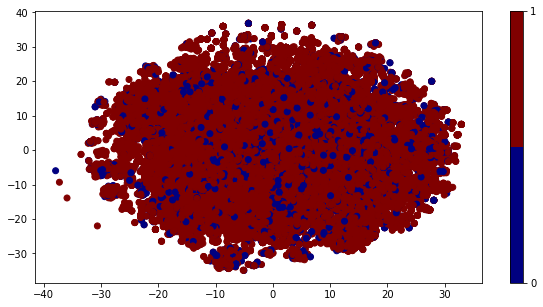

In [ ]:
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE
xtsne= TSNE(perplexity=50, n_jobs=7)
results= xtsne.fit_transform(tr_pca_essay)
vis_x= results[:,0]
vis_y= results[:,1 ]
plt.figure(figsize=(10,5))
plt.scatter(x=vis_x, y=vis_y,c= train_y,cmap= plt.cm.get_cmap("jet",2))
plt.colorbar(ticks= range(2))
plt.show()

In [ ]:
tr_fin_pca= hstack([tr_allcols_sparse,tr_pca_essay])
cv_fin_pca= hstack([cv_allcols_sparse,cv_pca_essay])
te_fin_pca= hstack([te_allcols_sparse,te_pca_essay])

In [ ]:
with open('/home/satya_anuragh/'+'tr_fin_pca.pkl','wb') as trpca:
    pickle.dump(tr_fin_pca,trpca)
with open('/home/satya_anuragh/'+'cv_fin_pca.pkl','wb') as cvpca:
    pickle.dump(cv_fin_pca,cvpca)
with open('/home/satya_anuragh/'+'te_fin_pca.pkl','wb') as tepca:
    pickle.dump(te_fin_pca,tepca)

In [ ]:
with open('/home/satya_anuragh/'+'tr_fin_pca.pkl','rb') as trtf3:
    tr_fin_pca= pickle.load(trtf3)
with open('/home/satya_anuragh/'+'cv_fin_pca.pkl','rb') as cvtf3:
    cv_fin_pca= pickle.load(cvtf3)
with open('/home/satya_anuragh/'+'te_fin_pca.pkl','rb') as tetf3:
    te_fin_pca= pickle.load(tetf3)

In [ ]:
print(tr_fin_pca.shape)

(69918, 1016)


In [ ]:
##Data Resampling using SMOTE

In [ ]:
val_counts= data["project_is_approved"].value_counts()
print(val_counts)

1    92706
0    16542
Name: project_is_approved, dtype: int64


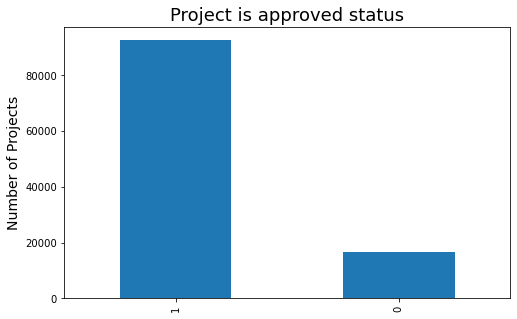

In [ ]:
val_counts.plot(kind='bar',figsize=(8,5))
plt.title("Project is approved status", fontsize=18)
plt.ylabel("Number of Projects",fontsize=14)
plt.show()

In [ ]:
pip install imblearn

     |████████████████████████████████| 206 kB 5.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
train_x_fin_dense= tr_fin_pca.todense()

In [ ]:
from imblearn.over_sampling import SMOTE
smt= SMOTE(random_state=20)
train_x_smt, train_y_smt = smt.fit_resample(train_x_fin_dense,train_y)

In [ ]:
train_y_smt.value_counts()

0    59331
1    59331
Name: project_is_approved, dtype: int64

<AxesSubplot:>

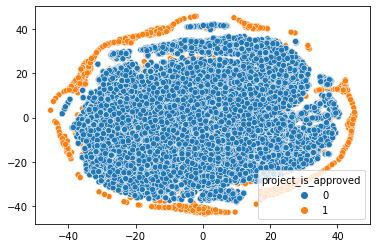

In [ ]:
from sklearn.manifold import TSNE
xtsne=TSNE(perplexity=50, n_jobs=7)
results=xtsne.fit_transform(train_x_smt)
sns.scatterplot(results[:,0],results[:,1],hue=train_y_smt,legend= 'full')

In [ ]:
from imblearn.combine import SMOTETomek
smtom= SMOTETomek(random_state=20)
train_x_smtek, train_y_smtek= smtom.fit_resample(train_x_fin_dense,train_y)
print(train_y_smtek.value_counts())

0    59304
1    59304
Name: project_is_approved, dtype: int64


In [ ]:
with open('/home/satya_anuragh/'+'tr_x_smtek.pkl','wb') as trsmtek:
    pickle.dump(train_x_smtek,trsmtek)
with open('/home/satya_anuragh/'+'tr_y_smtek.pkl','wb') as tysmtek:
    pickle.dump(train_y_smtek,tysmtek)

In [ ]:
with open('/home/satya_anuragh/'+'tr_x_smtek.pkl','rb') as trsmtek:
    train_x_smtek= pickle.load(trsmtek)
with open('/home/satya_anuragh/'+'tr_y_smtek.pkl','rb') as tysmtek:
    train_y_smtek=pickle.load(tysmtek)

<AxesSubplot:>

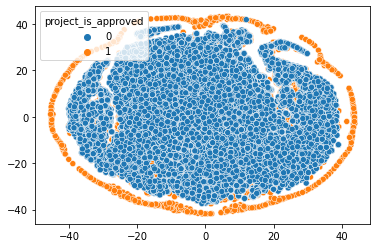

In [ ]:
from sklearn.manifold import TSNE
xtsne=TSNE(perplexity=50, n_jobs=7)
results=xtsne.fit_transform(train_x_smtek)
sns.scatterplot(results[:,0],results[:,1],hue=train_y_smtek,legend= 'full')

###Fitting XGBoost Algorithm on the TFIDF Vecrtorized(ESSAY variable and the rest of the columns)

In [ ]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [120,130,150,200,240], 'max_depth':[2, 3, 4]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1)
rs.fit(tr_w2v_fin,train_y)

[20:46:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

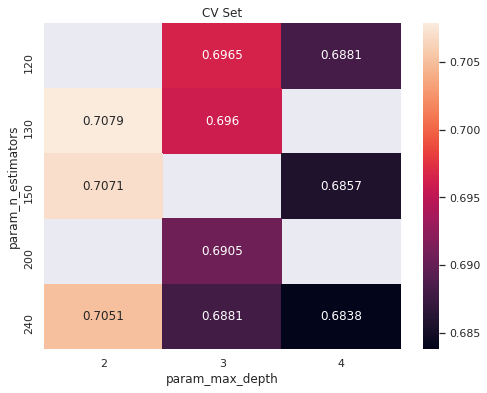

In [ ]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score']]
plt.figure(figsize=(8,6))
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.title("CV Set")
plt.show()

In [ ]:
gbdt = XGBClassifier(eval_metric=['auc'],max_depth=2,n_estimators=240, gamma=0.75,subsample=0.75,colsample_bylevel=0.75,colsample_bytree=0.75,min_child_weight=9)
gbdt.fit(tr_fin_pca,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
              colsample_bynode=1, colsample_bytree=0.75, eval_metric=['auc'],
              gamma=0.75, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=240, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.75, tree_method='exact',
              validate_parameters=1, verbosity=None)

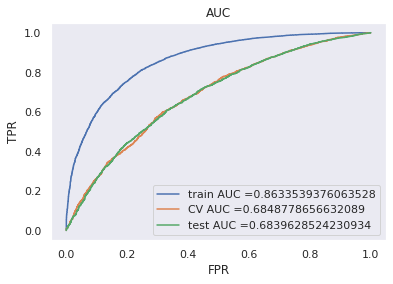

In [ ]:
tr_pred= gbdt.predict_proba(tr_fin_pca)
cv_pred= gbdt.predict_proba(cv_fin_pca)
te_pred= gbdt.predict_proba(te_fin_pca)

train_fpr, train_tpr, tr_thresholds = roc_curve(train_y,tr_pred[:,1])
cv_fpr, cv_tpr, cv_thresholds = roc_curve(cv_y,cv_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_y,te_pred[:,1])

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

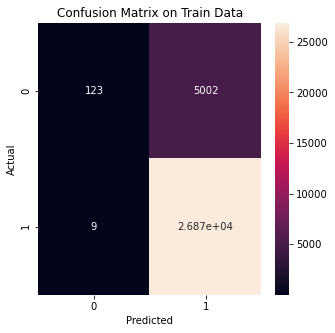

In [ ]:
from sklearn.metrics import confusion_matrix
tr_pred2= gbdt.predict(tr_fin_pca)
tr_c= confusion_matrix(train_y,tr_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(tr_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Train Data")
plt.show()

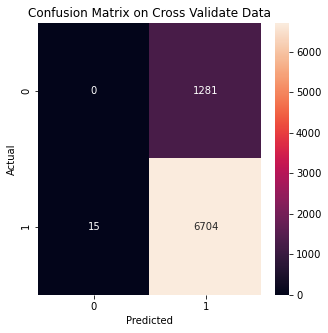

In [ ]:
from sklearn.metrics import confusion_matrix
cv_pred2= gbdt.predict(cv_fin_pca)
cv_c= confusion_matrix(cv_y,cv_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(cv_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Cross Validate Data")
plt.show()

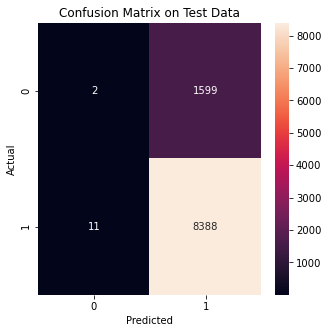

In [ ]:
from sklearn.metrics import confusion_matrix
te_pred2= gbdt.predict(te_fin_pca)
te_c= confusion_matrix(test_y,te_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(te_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Test Data")
plt.show()

###<font color='red'><b> Preparing the Datasets using the TFIDFW2Vec Vectorizer</b></font>

In [ ]:
with open('/home/satya_anuragh/'+'glove_vectors','rb') as gv:
    glove_vectors= pickle.load(gv)
    glove_words= set(glove_vectors.keys())

In [ ]:
print(len(glove_words))

51510


In [ ]:
tfidf_model= TfidfVectorizer()
tfidf_model.fit(data["essay"].values)

dictionary= dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words= set(tfidf_model.get_feature_names())

In [ ]:
print(len(tfidf_words))

56345


Converting each row item in the essay variable of the Train dataset into a vector and storing the same in different list.

In [ ]:
tr_tfidf_w2v_vectors= []

for line in tqdm(train_x["essay"].values):
        tr_vector = np.zeros(300)
        tr_tf_idf_weight =0
        for word in line.split():
            if (word in glove_words) and (word in tfidf_words):
                tr_vec= glove_vectors[word]
                tr_tf_idf = dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                tr_vector += (tr_vec * tr_tf_idf) # calculating tfidf weighted w2v
                tr_tf_idf_weight += tr_tf_idf
        if tr_tf_idf_weight != 0:
            tr_vector /= tr_tf_idf_weight
        tr_tfidf_w2v_vectors.append(tr_vector)

print(len(tr_tfidf_w2v_vectors))
print(len(tr_tfidf_w2v_vectors[0]))

100%|██████████| 32000/32000 [01:00<00:00, 528.02it/s]

32000
300


Converting each row item in the essay variable of the Cross-Validation dataset into a vector and storing the same in different list.

In [ ]:
cv_tfidf_w2v_vectors= []

for line in tqdm(cv_x["essay"].values):
        cv_vector = np.zeros(300)
        cv_tf_idf_weight =0
        for word in line.split():
            if (word in glove_words) and (word in tfidf_words):
                cv_vec= glove_vectors[word]
                cv_tf_idf = dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                cv_vector += (cv_vec * cv_tf_idf) # calculating tfidf weighted w2v
                cv_tf_idf_weight += cv_tf_idf
        if cv_tf_idf_weight != 0:
            cv_vector /= cv_tf_idf_weight
        cv_tfidf_w2v_vectors.append(cv_vector)

print(len(cv_tfidf_w2v_vectors))
print(len(cv_tfidf_w2v_vectors[0]))

100%|██████████| 8000/8000 [00:14<00:00, 537.54it/s]

8000
300


Converting each row item in the essay variable of the Test dataset into a vector and storing the same in different list.

In [ ]:
te_tfidf_w2v_vectors= []

for line in tqdm(test_x["essay"].values):
        te_vector = np.zeros(300)
        te_tf_idf_weight =0
        for word in line.split():
            if (word in glove_words) and (word in tfidf_words):
                te_vec= glove_vectors[word]
                te_tf_idf = dictionary[word]*(line.count(word)/len(line.split())) # getting the tfidf value for each word
                te_vector += (te_vec * te_tf_idf) # calculating tfidf weighted w2v
                te_tf_idf_weight += te_tf_idf
        if te_tf_idf_weight != 0:
            te_vector /= te_tf_idf_weight
        te_tfidf_w2v_vectors.append(te_vector)

print(len(te_tfidf_w2v_vectors))
print(len(te_tfidf_w2v_vectors[0]))

100%|██████████| 10000/10000 [00:20<00:00, 497.77it/s]

10000
300


In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_w2v_vectors.pkl','wb') as trw2v:
    pickle.dump(tr_tfidf_w2v_vectors,trw2v)
with open('/home/satya_anuragh/'+'cv_tfidf_w2v_vectors.pkl','wb') as cvw2v:
    pickle.dump(cv_tfidf_w2v_vectors,cvw2v)
with open('/home/satya_anuragh/'+'te_tfidf_w2v_vectors.pkl','wb') as tew2v:
    pickle.dump(te_tfidf_w2v_vectors,tew2v)

In [ ]:
with open('/home/satya_anuragh/'+'tr_tfidf_w2v_vectors.pkl','rb') as trw2v:
    tr_tfidf_w2v_vectors= pickle.load(trw2v)
with open('/home/satya_anuragh/'+'cv_tfidf_w2v_vectors.pkl','rb') as cvw2v:
    cv_tfidf_w2v_vectors= pickle.load(cvw2v)
with open('/home/satya_anuragh/'+'te_tfidf_w2v_vectors.pkl','rb') as tew2v:
    te_tfidf_w2v_vectors= pickle.load(tew2v)

Converting the above lists into arrays

In [ ]:
np.array(tr_tfidf_w2v_vectors)
np.array(cv_tfidf_w2v_vectors)
np.array(te_tfidf_w2v_vectors)

array([[-0.00136798,  0.06939083,  0.02367648, ...,  0.12971789,
         0.12771377,  0.03504675],
       [ 0.01564386, -0.00402246, -0.01021279, ...,  0.17962234,
         0.04409127, -0.1665846 ],
       [ 0.07248474,  0.04234559, -0.11328405, ...,  0.08922169,
         0.08069995,  0.01597197],
       ...,
       [ 0.1615374 , -0.02214232,  0.04403199, ...,  0.21843333,
         0.16837688,  0.1190179 ],
       [-0.03858911, -0.05587174,  0.02362469, ...,  0.15597819,
         0.12292258, -0.04087431],
       [ 0.08417938, -0.06533816,  0.02561217, ...,  0.02769992,
         0.1203658 ,  0.14849315]])

In [ ]:
cols=list(range(0,300))

In [ ]:
tr_w2v_df= pd.DataFrame(tr_tfidf_w2v_vectors,columns=cols)
cv_w2v_df= pd.DataFrame(cv_tfidf_w2v_vectors,columns=cols)
te_w2v_df= pd.DataFrame(te_tfidf_w2v_vectors,columns=cols)

In [ ]:
print(tr_w2v_df.shape)
print(cv_w2v_df.shape)
print(te_w2v_df.shape)

(32000, 300)
(8000, 300)
(10000, 300)


In [ ]:
tr_w2v_fin= pd.concat([tr_all_cols,tr_w2v_df],axis=1)
cv_w2v_fin= pd.concat([cv_all_cols,cv_w2v_df],axis=1)
te_w2v_fin= pd.concat([te_all_cols,te_w2v_df],axis=1)

In [ ]:
print(tr_w2v_fin.shape)
print(cv_w2v_fin.shape)
print(te_w2v_fin.shape)

(32000, 316)
(8000, 316)
(10000, 316)


Stacking all the modified variables to create the Train, Cross-Validation and the Test Datasets

## <font color='green'><b> Applying XGBoost on the TFIDF Vectorised Essay variable and other variables</b></font>

Trying out different hyperparameters for No.of Estimators and the Gamma Values.

In [ ]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

gbdt = XGBClassifier()

grid_params = {'n_estimators': [100,120,130,150,200], 'max_depth':[2, 3, 4, 5]}
 
rs = RandomizedSearchCV(gbdt,grid_params ,cv=3, scoring='roc_auc',n_jobs=-1)
rs.fit(tr_w2v_fin,train_y)

[20:09:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [ ]:
print(rs.best_score_)
print(rs.best_params_)
print(rs.best_index_)
print(rs.cv_results_.get('mean_test_score'))

0.7079094002249474
{'n_estimators': 130, 'max_depth': 2}
9
[0.69440552 0.68349039 0.70551673 0.69599015 0.68570015 0.70714405
 0.68737536 0.6904817  0.70765043 0.7079094 ]


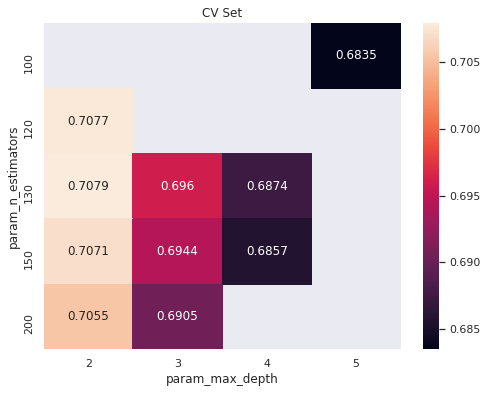

In [ ]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(rs.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score']]
plt.figure(figsize=(8,6))
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.title("CV Set")
plt.show()

In [ ]:
gbdt = XGBClassifier(eval_metric=['auc'],max_depth=2,n_estimators=130, gamma=0.75,subsample=0.7,colsample_bylevel=0.7,colsample_bytree=0.,min_child_weight=7)
gbdt.fit(tr_w2v_fin,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.0, eval_metric=['auc'],
              gamma=0.75, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=130, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

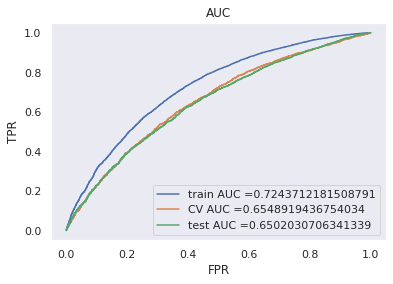

In [ ]:
tr_pred= gbdt.predict_proba(tr_w2v_fin)
cv_pred= gbdt.predict_proba(cv_w2v_fin)
te_pred= gbdt.predict_proba(te_w2v_fin)

train_fpr, train_tpr, tr_thresholds = roc_curve(train_y,tr_pred[:,1])
cv_fpr, cv_tpr, cv_thresholds = roc_curve(cv_y,cv_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(test_y,te_pred[:,1])

plt.close
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

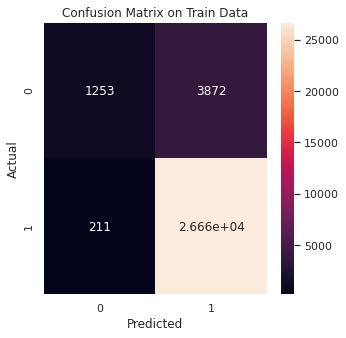

In [ ]:
from sklearn.metrics import confusion_matrix
tr_pred2= gbdt.predict(tr_w2v_fin)
tr_c= confusion_matrix(train_y,tr_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(tr_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Train Data")
plt.show()

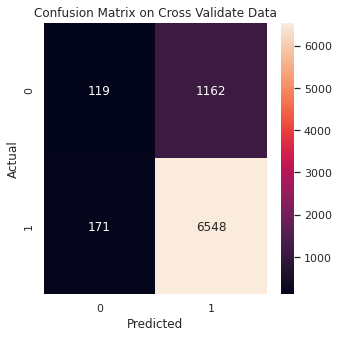

In [ ]:
cv_pred2= gbdt.predict(cv_w2v_fin)
cv_c= confusion_matrix(cv_y,cv_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(cv_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Cross Validate Data")
plt.show()

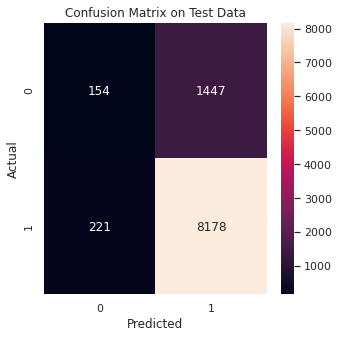

In [ ]:
te_pred2= gbdt.predict(te_w2v_fin)
te_c= confusion_matrix(test_y,te_pred2)
plt.figure(figsize=(5,5))
sns.heatmap(te_c,annot=True,fmt='.4g')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix on Test Data")
plt.show()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [ ]:
from prettytable import PrettyTable

In [ ]:
P= PrettyTable()
P.field_names = ["Vectorizer", "Model","Depth","No.of Estimators", "Gamma Value", "Train AUC","Test AUC"]
P.add_row(["TFIDF", "XGBoost", 2,240,0.75,0.8633,0.6839])
P.add_row(["TFIDFW2V","XGBoost",2,130,0.75,0.72437,0.65020])

In [ ]:
print(P)

+------------+---------+-------+------------------+-------------+-----------+----------+
| Vectorizer |  Model  | Depth | No.of Estimators | Gamma Value | Train AUC | Test AUC |
+------------+---------+-------+------------------+-------------+-----------+----------+
|   TFIDF    | XGBoost |   2   |       240        |     0.75    |   0.8633  |  0.6839  |
|  TFIDFW2V  | XGBoost |   2   |       130        |     0.75    |  0.72437  |  0.6502  |
+------------+---------+-------+------------------+-------------+-----------+----------+
